# Figure 05. Physical overlaps of genomic regions associated with

susceptibility across toxicants

In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: easyXpress
Loading required package: RColorBrewer
Loading required package: cowplot

Attaching package: 'cowplot'

The following object is masked from 'package:lubridate':

    stamp

Loading required package: magrittr

Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract

Loading required package: ggbeeswarm
Loading required package: ggrepel
Loading required package: grid
Loading required package: gridExtra

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Loading required package: sommer
Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: crayon

Attaching pa


Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows


Attaching package: 'flextable'

The following objects are masked from 'package:kableExtra':

    as_image, footnote

The following objects are masked from 'package:crayon':

    bold, italic, style

The following object is masked from 'package:purrr':

    compose

here() starts at /Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript

$strain_table
$strain_table$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.html"

$strain_table$tsv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.tsv.zip"

$strain_table$docx
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.docx"

$strain_table$csv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.csv"


$tox_table_ft
$tox_table_ft$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.html"

$tox_table_ft$tsv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.tsv.zip"

$tox_table_ft$docx
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.docx"

$tox_table_ft$csv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.csv"


$trait_table
$trait_table$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S3/table_S3.html"

$trait_table$tsv
[1] "

# Inputs

In [ ]:

# Path to neamscan output directory
ns_dir <- "data/processed/20231116_Analysis_NemaScan"

# toxicant condition metadata
tox_meta_fn <- "data/processed/tox_data/tox_metadata.csv"

# LD between peak markers output by `pull_overlap_LD.R`
# inbred_qtl_overlap_peak_ld_fn <- "data/processed/qtl_overlaps/inbred_qtl_overlap_peak_LD.tsv.gz"

# inbred qtl overlaps output by `find_overlaps.R`
inbred_qtl_overlaps_fn <- "data/processed/interval_overlap/inbred_qtl_overlaps.csv"

chr_lens_fn <- "data/raw/c_elegans_chr_lengths.tsv"


# Main

In [ ]:

chr_lens <- data.table::fread(chr_lens_fn) %>%
  dplyr::select(CHROM, startPOS = start, endPOS = stop)

tox_meta <- data.table::fread(tox_meta_fn) %>%
  dplyr::mutate(nice_drug_label2 = stringr::str_replace(nice_drug_label2, pattern = "uM", replacement = "µM"))


# Load the Inbred QTL that overlap with another
# output of find_overlaps.R
inbred_overlaps <- data.table::fread(inbred_qtl_overlaps_fn)

# Get all unique peak IDs that are involved in overlaps from both sides
overlapping_peak_ids <- inbred_overlaps %>%
  dplyr::select(peakidA, peakidB) %>%
  tidyr::pivot_longer(cols = everything(), values_to = "peakid") %>%
  dplyr::filter(!is.na(peakid)) %>%
  dplyr::pull(peakid) %>%
  unique()

qtl <- data.table::fread(
  glue::glue("{ns_dir}/INBRED/Mapping/Processed/QTL_peaks_inbred.tsv")
) %>%
  dplyr::mutate(
    var_type = ifelse(stringr::str_detect(trait, pattern = "CV_length"), "CV_length", "length"),
    join_var = stringr::str_replace_all(trait, pattern = "length_|CV_length_", replacement = "")
  ) %>%
  dplyr::rename(POS = peakPOS) %>% # rename to just peak
  dplyr::filter(var_type == "length") %>%
  dplyr::distinct() %>%
  dplyr::left_join(., tox_meta, by = "trait") %>%
  dplyr::arrange(
    desc(big_class),
    desc(nice_drug_label2)
  ) %>%
  dplyr::mutate(
    nice_drug_label2 = factor(
      nice_drug_label2,
      levels = unique(nice_drug_label2)
    )
  ) %>%
  dplyr::mutate(overlap = ifelse(marker %in% overlapping_peak_ids, TRUE, FALSE)) %>%
  dplyr::mutate(big_class = case_when(
    big_class == "Flame Retardant" ~ "Flame\nRetardant",
    TRUE ~ big_class
  ))

# shape chr_lens for plotting
chr_lens2 <- chr_lens %>%
  tidyr::pivot_longer(cols = -CHROM, names_to = "poop", values_to = "POS") %>%
  dplyr::select(-poop) %>% # add in the full extents of the chromosomes
  dplyr::mutate(
    trait = tail(qtl$trait, n = 1),
    nice_drug_label2 = tail(qtl$nice_drug_label2, n = 1),
    big_class = tail(qtl$big_class, n = 1),
    var_type = "length"
  )


class.pal.df <- tibble::tibble(
  col = c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#D55E00"),
  big_class = c("Control", "Flame\nRetardant", "Fungicide", "Herbicide", "Insecticide", "Metal")
)

# class colors for y
man_pal <- qtl %>%
  dplyr::distinct(big_class) %>%
  dplyr::left_join(class.pal.df) %>%
  dplyr::pull(col)


Joining with `by = join_by(big_class)`

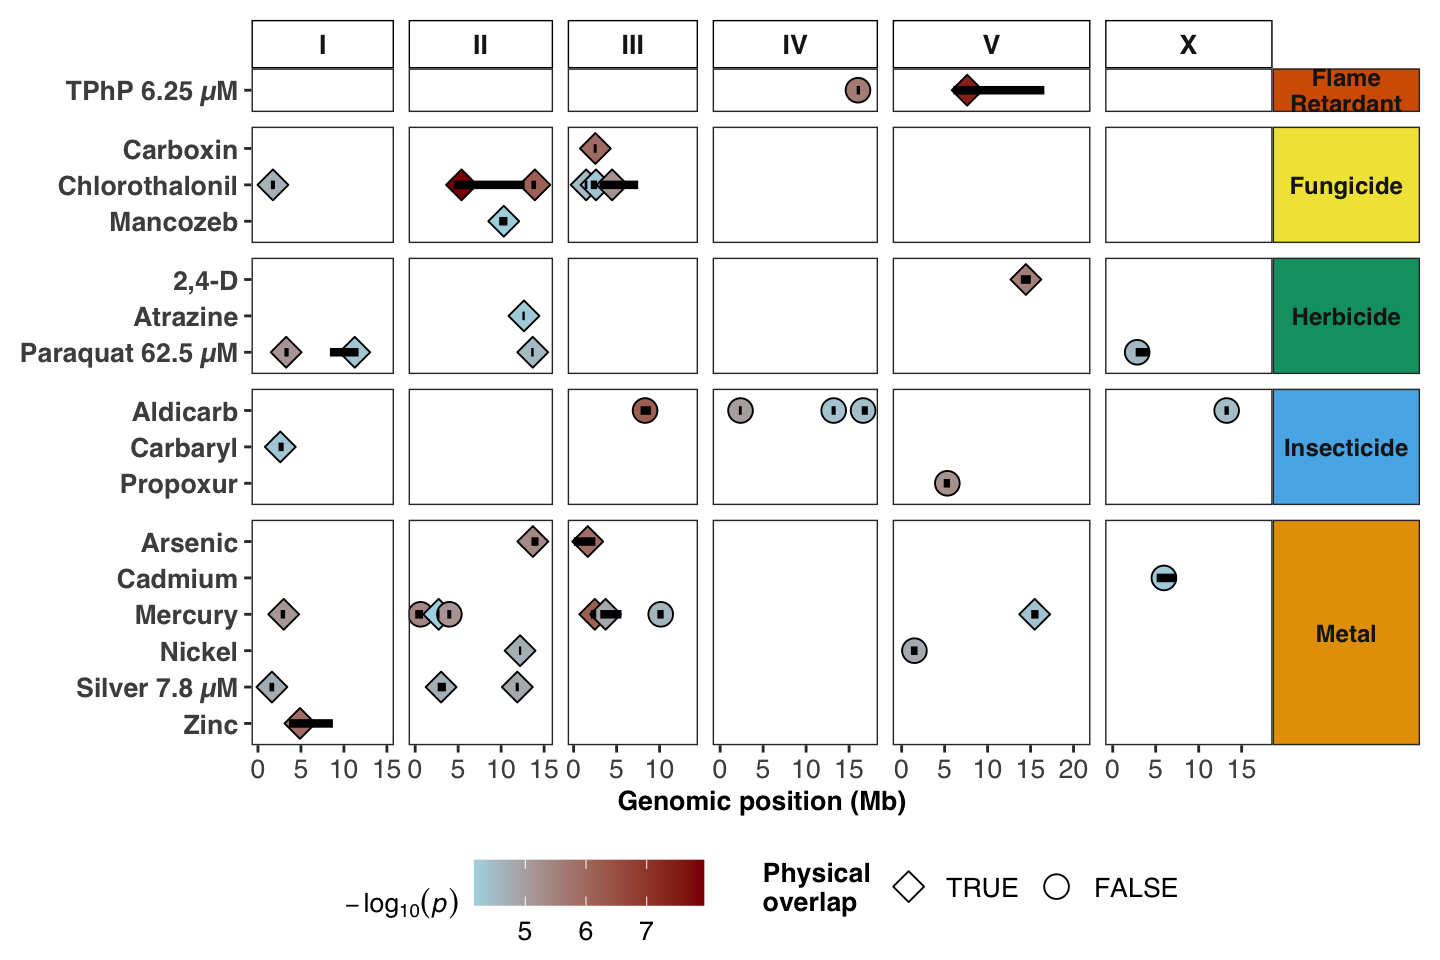

In [ ]:
qtl_overlaps


In [ ]:
save_plot(
  qtl_overlaps,
  figure_fns$qtl_overlaps,
  w_in = 7.5,
  h_in = 5
)
